In [ ]:
import os

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import json

def parse_sarcasm_json_dataset(file):
    for line in open(file, 'r'):
        yield json.loads(line)

In [ ]:
df = pd.read_pickle("../data/news_headlines_for_sarcasm_detection/Sarcasm_Headlines_Dataset_v2.json")
df

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love
...,...,...
566,that was what i felt when i was finally accept...,joy
36236,i take every day as it comes i m just focussin...,fear
76229,i just suddenly feel that everything was fake,sadness
131640,im feeling more eager than ever to claw back w...,joy


In [ ]:
df = df.drop(columns=['article_link'])
df

In [ ]:
# It is only fine-tuning, thus 400k data samples is a complete overkill. It can be reduced to 40k.
df = df.iloc[:40000]

,text,emotions
140764,i feel too pathetic,sadness
10714,i feel like i m the only guy on the planet tha...,anger
35177,i remember feeling shocked and on some level d...,surprise
122177,i just don t want to or i want to do my own th...,anger
98659,i feel impressed now,surprise
...,...,...
10560,i feel like wanna post everything i narrated a...,joy
5282,i really like the song the artists divine insp...,surprise
6187,i wake up feeling horrible and counting down t...,sadness
6813,i am feeling so irritated because this old man...,anger


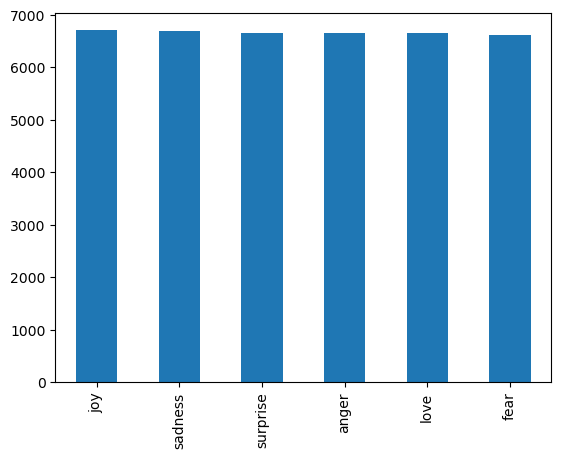

In [ ]:
data = df["is_sarcastic"]
data.value_counts().plot.bar()
plt.show()

In [ ]:
from datasets import Dataset

raw_dataset = Dataset.from_pandas(df)
raw_dataset

Dataset({
    features: ['text', 'emotions'],
    num_rows: 40000
})

In [ ]:
from transformers import AutoTokenizer

MAX_TOKENS = 128
EOS_TOKEN = "<|endoftext|>"
checkpoint = "gpt2"

tokenizer = AutoTokenizer.from_pretrained(
    checkpoint,
    eos_token=EOS_TOKEN,
    pad_token=EOS_TOKEN,
    max_length=MAX_TOKENS,
    is_split_into_words=True,
)

tokenizer.padding_side = "left"

In [ ]:
def tokenize_function(examples):
    examples = [ex + EOS_TOKEN for ex in examples['headline']]

    output = tokenizer(
        examples,
        add_special_tokens=True,
        max_length=MAX_TOKENS,
        truncation=True,
        padding=True,
    )

    # truncate input ids and attention mask to account for label shift
    output["input_ids"] = [x[:-1] for x in output["input_ids"]]
    output["attention_mask"] = [x[:-1] for x in output["attention_mask"]]
    return output

In [ ]:
tokenized_dataset = raw_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

In [ ]:
# Train set: 80%, Validation set: 10%, Test set: 10%
split_train_val_and_test_dataset = tokenized_dataset.train_test_split(train_size=0.8)
split_val_test_dataset = split_train_val_and_test_dataset["test"].train_test_split(test_size=0.5)

tokenized_train_dataset = split_train_val_and_test_dataset["train"]
tokenized_val_dataset = split_val_test_dataset["train"]
tokenized_test_dataset = split_val_test_dataset["test"]

In [ ]:
from transformers import DataCollatorWithPadding

batch_size = 16


def convert_to_tf_dataset(hf_dataset, collator, batch_size=batch_size, shuffle=False):
    return hf_dataset.to_tf_dataset(
        columns=["input_ids", "attention_mask"],
        label_cols=["is_sarcastic"],
        collate_fn=collator,
        shuffle=shuffle,
        batch_size=batch_size,
    )


data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset = convert_to_tf_dataset(hf_dataset=tokenized_train_dataset, collator=data_collator)
tf_val_dataset = convert_to_tf_dataset(hf_dataset=tokenized_val_dataset, collator=data_collator)
tf_test_dataset = convert_to_tf_dataset(hf_dataset=tokenized_test_dataset, collator=data_collator)

C:\Users\Karol\anaconda3\envs\ml-tf2gpu\lib\site-packages\datasets\arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
import Constants

# Callbacks
training_number = 1
model_name = "sarcasm_eng_gpt2"
training_folder = f"training_{training_number}"
checkpoint_filename = "cp-{epoch:04d}.ckpt"
training_path = os.path.join(Constants.TRAINING_CHECKPOINTS_PATH, model_name, training_folder)
checkpoint_path = os.path.join(training_path, checkpoint_filename)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True)

early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=3)

In [ ]:
checkpoint_path

'../training_checkpoints\\emotions_eng_gpt2\\training_1\\cp-{epoch:04d}.ckpt'

In [ ]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam

num_epochs = 10
# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs. Note that the tf_train_dataset here is a batched tf.data.Dataset,
# not the original Hugging Face Dataset, so its len() is already num_samples // batch_size.
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

optimizer = Adam(learning_rate=lr_scheduler)

In [ ]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, pad_token_id=tokenizer.pad_token_id, eos_token_id=tokenizer.eos_token_id, use_cache=False, num_labels=2)

All model checkpoint layers were used when initializing TFGPT2ForSequenceClassification.

Some layers of TFGPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.summary()

Model: "tfgp_t2for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
score (Dense)                multiple                  4608      
_________________________________________________________________
transformer (TFGPT2MainLayer multiple                  124439808 
Total params: 124,444,416
Trainable params: 124,444,416
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ["accuracy"]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
history = model.fit(tf_train_dataset, validation_data=tf_val_dataset, epochs=num_epochs,
                    callbacks=[checkpoint_cb, early_stop_cb])

2000/2000 [==============================] - 248s 118ms/step - loss: 0.7212 - accuracy: 0.7093 - val_loss: 0.2615 - val_accuracy: 0.8982

Epoch 00001: saving model to ../training_checkpoints\emotions_eng_gpt2\training_1\cp-0001.ckpt


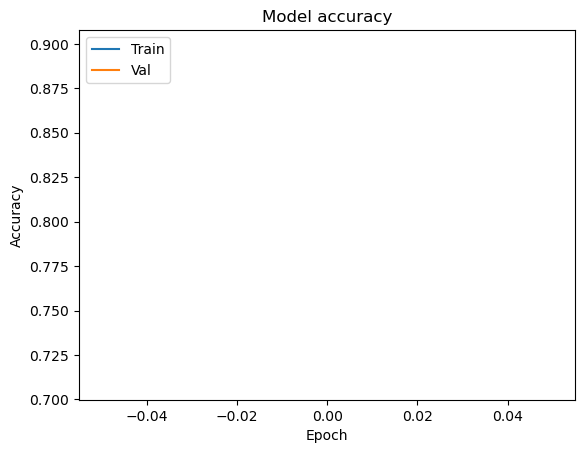

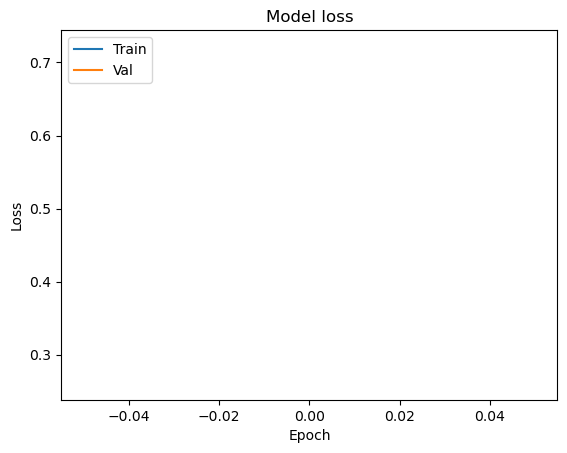

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig(f"../documentation/models/{model_name}/figures/{training_folder}_accuracy.png")
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig(f"../documentation/models/{model_name}/figures/{training_folder}_loss.png")
plt.show()

In [ ]:
import shutil

best_model_checkpoint_index = np.argmin(history.history["val_accuracy"]) + 1
best_model_weights_path = os.path.join(training_path, checkpoint_filename.format(epoch=best_model_checkpoint_index))
best_model = model
best_model.load_weights(best_model_weights_path)

shutil.rmtree(training_path)

In [ ]:
saved_model_name = f"{model_name}_{training_number}"

# Save to Saved Model format
best_model.save(os.path.join(Constants.SAVED_MODEL_LOCATION, saved_model_name, Constants.DEFAULT_MODEL_VERSION))

INFO:tensorflow:Assets written to: ../trained_models\emotions_eng_gpt2_4\1\assets


INFO:tensorflow:Assets written to: ../trained_models\emotions_eng_gpt2_4\1\assets


In [ ]:
# Evaluation
best_model.evaluate(tf_test_dataset, batch_size=32)

250/250 [==============================] - 10s 38ms/step - loss: 0.2434 - accuracy: 0.9043


[0.24335874617099762, 0.9042500257492065]

In [ ]:
# Getting predictions
prediction_logits = best_model.predict(tf_test_dataset)['logits']
probabilities = tf.nn.softmax(prediction_logits)
class_preds = np.argmax(probabilities, axis=1)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(tokenized_test_dataset['is_sarcastic'], class_preds)
recall = recall_score(tokenized_test_dataset['is_sarcastic'], class_preds)
f1 = f1_score(tokenized_test_dataset['is_sarcastic'], class_preds)

print(f"Precision score: ", precision)
print(f"Recall score: ", recall)
print(f"F1 score: ", f1)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

result = confusion_matrix(tokenized_test_dataset['is_sarcastic'], class_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=result)
disp.plot()
plt.savefig(f"../documentation/models/{model_name}/figures/{training_folder}_confmatrix.png")
plt.show()